In [23]:
#necassary imports #Smallest Coverage = 0.0683 arcsec, biggest = 3.54 arcsec
import numpy as np
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import math
import cmath
import PIL
from PIL import ImageDraw
import PIL.ImageTk
from tkinter import *
from tkinter import ttk
from matplotlib import colors
from pylab import rcParams
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
%matplotlib inline

C:\Users\User\Anaconda3a\lib\site-packages\matplotlib\__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [24]:
#Convert coordinates to ENU
def ENU(coords):
    E = -coords[0]*np.cos(coords[1])*np.sin(coords[2])
    N = coords[0]*np.cos(coords[1])*np.cos(coords[2])
    U = coords[0]*np.sin(coords[1])
    return np.array([E,N,U])

In [25]:
#Convert array into ENU
def ENUarray(coordsA):
    arrayInQuestion = np.zeros([len(coordsA[0]),3])
    for i in np.arange(len(coordsA[0])):
        arrayInQuestion[i] = ENU(coordsA[0:3,i])
    arrayInQuestion2 = np.zeros([len(arrayInQuestion[0]),len(arrayInQuestion)])
    for i in np.arange(len(arrayInQuestion2)):
        arrayInQuestion2[i] = arrayInQuestion[:,i]
    return arrayInQuestion2

In [26]:
coordsA = np.array([[1,2,3,4,3],[1,2,3,4,3],[1,2,3,4,3]])
arrayInQuestion = np.zeros([len(coordsA[0]),len(coordsA)])
for i in np.arange(len(coordsA[0])):
    arrayInQuestion[i] = ENU(coordsA[0:3,i])
arrayInQuestion2 = np.zeros([len(arrayInQuestion[0]),len(arrayInQuestion)])
for i in np.arange(len(arrayInQuestion2)):
    arrayInQuestion2[i] = arrayInQuestion[:,i]
print(arrayInQuestion2)

[[-0.45464871  0.7568025   0.41912325 -1.97871649  0.41912325]
 [ 0.29192658  0.34635638  2.94025543  1.70899993  2.94025543]
 [ 0.84147098  1.81859485  0.42336002 -3.02720998  0.42336002]]


In [27]:
#Convert ENU to xyz
def xyz(coords,L):
    x = -np.sin(L)*coords[1]+np.cos(L)*coords[2]
    y = coords[0]
    z = np.cos(L)*coords[1]+np.sin(L)*coords[2]
    return np.array([x,y,z])

In [28]:
#Convert xyz to uvw
def uvw(coords1,coords2,lam,delta,h):
    Bx = coords2[0]-coords1[0]
    By = coords2[1]-coords1[1]
    Bz = coords2[2]-coords1[2]
    uR = np.sin(h)*Bx+np.cos(h)*By
    vR = -np.sin(delta)*np.cos(h)*Bx+np.sin(delta)*np.sin(h)*By+np.cos(delta)*Bz
    wR = np.cos(delta)*np.cos(h)*Bx-np.cos(delta)*np.sin(h)*By+np.sin(delta)*Bz
    u = uR/(lam*1000)
    v = vR/(lam*1000)
    w = wR/(lam*1000)
    return np.array([u,v,w])

In [29]:
#Conv,ert from r,theta,phi to uvw all in one
def skipit(coords1,coords2,L,lam,delta,h):
    return uvw(xyz(ENU(coords1),L),xyz(ENU(coords2),L),lam,delta,h)

In [30]:
def length(vector):
    modStart = 0
    for i in np.arange(len(vector)):
        modStart += vector[i]**2
    return np.sqrt(modStart)

In [31]:
#Create all the baseline uv vectors
def uvTrack(coords,L,lam,delta,h):
    uv = np.zeros([len(coords[1])*(len(coords[1])-1),3])
    k = 0
    for i in np.arange(len(coords[1])):
        for j in np.arange(len(coords[1])-1-i):
            uv[k] = skipit(coords[:,i],coords[:,j+i+1],L,lam,delta,h)
            k = k+1
    for i in np.arange(len(coords[1])):
        for j in np.arange(len(coords[1])-1-i):
            uv[k] = -skipit(coords[:,i],coords[:,j+i+1],L,lam,delta,h)
            k = k+1
    return uv

In [32]:
#Find uv track over time
def timetrack(coords,L,lam,delta,hCen,hStep,hSteps): #H as an array
    uvFu = np.array([])
    uvFv = np.array([])
    for i in np.arange(hSteps):
        uvFu = np.array(list(uvFu)+list(uvTrack(coords,L,lam,delta,h-hStep*hSteps/2+i*hStep)[:,0]))
        uvFv = np.array(list(uvFv)+list(uvTrack(coords,L,lam,delta,h-hStep*hSteps/2+i*hStep)[:,1]))
    return np.array([uvFu,uvFv])

In [33]:
#Subtract the uv coverage from the image, fourier transformation aplication to the image is to come
def Subtraction(image,uvCover):
    #im2 = np.asarray(image)
    #imS = np.zeros([len(im2),len(im2[0])])
    #for i in np.arange(len(im2)):
    #    for j in np.arange(len(im2[0])):
    #        imS[i,j] = np.trapz(im2[i,j])
    imUsed = np.fft.fft2(image) #fft.fft.real may be fine
    finWid = len(imUsed)
    finLen = len(imUsed[0])
    staLen = max(uvCover[0])
    staWid = max(uvCover[1])
    sampleUsed = np.zeros([len(uvCover),len(uvCover[0])])
    sampleUsed[0] = uvCover[0]*finLen/(2*staLen)+finLen/2
    sampleUsed[1] = uvCover[1]*finLen/(2*staLen)+finLen/2
    sampleUsed2 = np.zeros([len(sampleUsed[0]),len(sampleUsed)])
    for i in np.arange(len(sampleUsed[0])):
        sampleUsed2[i] = sampleUsed[:,i]
    track = PIL.Image.new('RGB', (finLen,finWid), 'black')
    mask = ImageDraw.Draw(track)
    coords = sampleUsed2
    pointSize = 1
    for (x,y) in coords:
        mask.rectangle([x,y,x+pointSize-1,y+pointSize-1], fill = 'white')
    plt.imshow(track, 'gray')
    #mask.rectangle([0,0,1000,1000], fill = 'white') #Use this for a full image
    trackF = np.zeros([track.size[1],track.size[0]])
    trackF = imUsed*np.asarray(track)[:,:,0]/255
    return np.fft.ifft2(trackF) #put an inverse fourier transformation here

In [34]:
#Finds the maximum and the minimum baseline, coordinate should be given in xyz or ENU
def minmax(position):
    totLen = 0
    for i in np.arange(len(position[0])):
        totLen += i
    coverLength = np.zeros(totLen)
    m = 0
    for i in np.arange(len(position[0])):
        for j in np.arange(len(position[0])-i-1):
            coverLength[m] = length(position[:,i]-position[:,i+j+1])
            m += 1
    return np.array([min(coverLength),max(coverLength)])

In [35]:
#Scale the UV track to the Fourier transformed image
def ScaleUVTrack(uvCover,Res,image):
    resRad = np.radians(Res/(60.*60.))
    #sizeAng = (resRad)*np.array([image.size[0],image.size[1]])
    inversedSizeAng = 2./resRad
    pixSize = np.array([inversedSizeAng/len(np.fft.fft2(image)),inversedSizeAng/len(np.fft.fft2(image)[0])])
    return 1000.*np.array([uvCover[0]/pixSize[0],uvCover[1]/pixSize[1]])

In [36]:
def makeMask(ima,uvCover,Res):
    finWid = len(np.fft.fft2(ima))
    finLen = len(np.fft.fft2(ima)[0])
    sampleUsed = ScaleUVTrack(uvCover,Res,ima)
    sampleUsed2 = np.zeros([len(sampleUsed[0]),len(sampleUsed)])
    for i in np.arange(len(sampleUsed[0])):
        sampleUsed2[i] = sampleUsed[:,i]
        sampleUsed2[i,1] = -sampleUsed2[i,1]
    track = PIL.Image.new('RGB', (finLen,finWid), 'black')
    mask = ImageDraw.Draw(track)
    coord = sampleUsed2
    pointSize = 1
    Coord = np.arange(50)-25
    Coord2 = np.zeros([len(Coord)**2,2])
    m = 0
    for i in np.arange(len(Coord)):
        for j in np.arange(len(Coord)):
            Coord2[m,0] = Coord[i]
            Coord2[m,1] = Coord[j]
            m+=1
    for (x,y) in coord:
        mask.rectangle([x+finLen/2,y+finWid/2,x+finLen/2+pointSize-1,y+finWid/2+pointSize-1], fill = 'white')
    #mask.rectangle([0,0,1000,1000], fill = 'white') #Use this for a full image
    return track

In [37]:
def FourierTimesTrack(image,uvCover,Res):
    #im2 = np.asarray(image)
    #imS = np.zeros([len(im2),len(im2[0])])
    #for i in np.arange(len(im2)):
    #    for j in np.arange(len(im2[0])):
    #        imS[i,j] = np.trapz(im2[i,j])
    imUsed = np.fft.fftshift(np.fft.fft2(image)) #fft.fft.real may be fine
    uvTrack = makeMask(im,uvCover,Res)
    #plt.imshow(uvTrack, cmap = 'gray')
    trackF = np.zeros([uvTrack.size[1],uvTrack.size[0]])
    trackF = imUsed*np.asarray(uvTrack)[:,:,0]/255
    return trackF

In [38]:
def LoadingImage(*args):
    global im, shownImage, imDis
    im = PIL.Image.open(loaded.get())
    #shownImage.grid_forget()
    imDis = PIL.ImageTk.PhotoImage(im.resize([150,150]))
    shownImage = refCan.create_image(75,75, image=imDis)

In [39]:
def ChooseArray(*args):
    global Ea, No, arrayDisplay, plotDisplay, arrayBox, arrDisFig, arrCoordsENU
    arrDisFig = plt.figure(1)
    Ea = arrCoordsENU[arrayBox.curselection()[0]][0]
    No = arrCoordsENU[arrayBox.curselection()[0]][1]
    ELim = np.array([min(Ea-50)/1000,max(Ea+50)/1000])
    NLim = np.array([min(No-50)/1000,max(No+50)/1000])
    plt.clf()
    plt.xlabel('East(km)')
    plt.ylabel('North(km)')
    plt.plot(Ea/1000,No/1000,'.')

    arrayDisplay = FigureCanvasTkAgg(arrDisFig,master = frame)

    plotDisplay = arrayDisplay.get_tk_widget()
    plotDisplay.grid(column=3,row=2,rowspan=10)

In [40]:
def GrabHourSlide(e):
    global hourMove ,minHoVal, maxHoVal
    if ((e.x < minHoVal+3) and (e.x > minHoVal-3)):
        hourMove = 1
    else:
        if ((e.x < maxHoVal+3) and (e.x > maxHoVal-3)):
            hourMove = 2
        else:
            hourMove = 0

In [41]:
def ReleaseHour(e):
    global hourMove
    hourMove = 0
    hourCanvas = Canvas(frame, width=260,height=50)
    hourCanvas.grid(column=4,row=6,columnspan=2)
    hourCanvas.create_line(5,25,255,25)
    hourCanvas.create_rectangle(minHoVal-3,10,minHoVal+3,40,fill='black')
    hourCanvas.create_rectangle(maxHoVal-3,10,maxHoVal+3,40,fill='black')

    hourCanvas.bind('<Button - 1>', lambda e: GrabHourSlide(e))
    hourCanvas.bind('<ButtonRelease - 1>', lambda e: ReleaseHour(e))
    hourCanvas.bind('<B1-Motion>', lambda e: Slide(e))

In [42]:
def Slide(e):
    global hourMove, minHoVal, maxHoVal, minHour, maxHour
    if (hourMove == 1):
        minHoVal = e.x
        if (maxHoVal < minHoVal):
            maxHoVal = minHoVal
    if (hourMove == 2):
        maxHoVal = e.x
        if (maxHoVal < minHoVal):
            minHoVal = maxHoVal
    if (minHoVal < 5):
        minHoVal = 5
    if (maxHoVal < 5):
        minHoVal = 5
        maxHoVal = 5
    if (maxHoVal > 255):
        maxHoVal = 255
    if (minHoVal > 255):
        minHoVal = 255
        maxHoVal = 255
    if (hourMove != 0):
        minHour.set((minHoVal-5)/250*24-12)
        maxHour.set((maxHoVal-5)/250*24-12)
        
        hourCanvas = Canvas(frame, width=260,height=50)
        hourCanvas.grid(column=4,row=6,columnspan=2)
        hourCanvas.create_line(5,25,255,25)
        hourCanvas.create_rectangle(minHoVal-3,10,minHoVal+3,40,fill='black')
        hourCanvas.create_rectangle(maxHoVal-3,10,maxHoVal+3,40,fill='black')

        hourCanvas.bind('<Button - 1>', lambda e: GrabHourSlide)
        hourCanvas.bind('<ButtonRelease - 1>', ReleaseHour)
        hourCanvas.bind('<B1-Motion>', lambda e: Slide)

In [67]:
def minHourDirect(*args):
    global hourMove, minHoVal, maxHoVal, minHour, maxHour
    if ((float(minHour.get()) <= 12) and (float(minHour.get()) >= -12) and (float(maxHour.get()) <= 12) and (float(maxHour.get()) >= -12)):
        if ((float(minHour.get()) > float(maxHour.get()))):
            maxHour.set(minHour.get())
    
        minHoVal = (float(minHour.get())+12)*250/24+5
        maxHoVal = (float(maxHour.get())+12)*250/24+5
    
        hourCanvas = Canvas(frame, width=260,height=50)
        hourCanvas.grid(column=4,row=6,columnspan=2)
        hourCanvas.create_line(5,25,255,25)
        hourCanvas.create_rectangle(minHoVal-3,10,minHoVal+3,40,fill='black')
        hourCanvas.create_rectangle(maxHoVal-3,10,maxHoVal+3,40,fill='black')

        hourCanvas.bind('<Button - 1>', lambda e: GrabHourSlide)
        hourCanvas.bind('<ButtonRelease - 1>', ReleaseHour)
        hourCanvas.bind('<B1-Motion>', lambda e: Slide)

In [45]:
def DeleteSelected(*args):
    global usedArrays
    relation.pop(usedArrays.curselection()[0])
    usedArrays.delete(usedArrays.curselection()[0])
    
    uvDisFig = plt.figure(2)
    plt.clf()
    for i in np.arange(len(relation)):
        U = relation[i][0]
        V = relation[i][1]
        plt.xlabel('U(klam)')
        plt.ylabel('V(klam)')
        plt.plot(U/1000,V/1000,'.')
    
        uvDisplay = FigureCanvasTkAgg(uvDisFig,master = frame)
        plotUVDisplay = uvDisplay.get_tk_widget()
        plotUVDisplay.grid(column=7,row=2,rowspan=10)

In [46]:
def AddSelected(*args):
    global usedArrays, arrayBox, telNames, relation, freq, declin, samFreq, minHour, maxHour, arrCoords, latitude
    usedArrays.insert(END, telNames[arrayBox.curselection()[0]] + ':      ' + "%.2f" %float(minHour.get()) + '-' + "%.2f" %float(maxHour.get()))
    hour = (float(minHour.get())/2.+float(maxHour.get())/2.)*np.pi/180
    relation.append(timetrack(arrCoords[arrayBox.curselection()[0]],float(latitude[arrayBox.curselection()[0]]),299792458/(float(freq.get())*10**6),float(declin.get())*np.pi/180,hour,2.*0.99726958*np.pi/(24*60*float(samFreq.get())),(float(maxHour.get())-float(minHour.get()))*60*float(samFreq.get())/0.99726958))
    
    uvDisFig = plt.figure(2)
    U = relation[len(relation)-1][0]
    V = relation[len(relation)-1][1]
    plt.xlabel('U(km)')
    plt.ylabel('V(km)')
    plt.plot(U,V,'.')
    
    uvDisplay = FigureCanvasTkAgg(uvDisFig,master = frame)

    plotUVDisplay = uvDisplay.get_tk_widget()
    plotUVDisplay.grid(column=7,row=2,rowspan=10)

In [47]:
def FFTDisplay(image):
    fftim = np.fft.fft2(image)
    step = np.fft.fftshift(fftim)
    absoluteFFT = abs(step)
    logFFT = np.log(absoluteFFT+1)
    maxes = np.zeros(len(logFFT))
    for i in np.arange(len(logFFT)):
        maxes[i] = max(logFFT[i])
    totMax = max(maxes)
    moddedFFT = logFFT*255/totMax
    return PIL.Image.fromarray(moddedFFT)

In [83]:
#This is the final calculation
def FindEverything(*args):
    #The Fourier Transform
    global im, fourCan, imFour, relation, uvCan, imCoverage, pixScale, fftuvCan, imFoAndTr, synCan, imSynBeam, imFinal, finCan
    imFourProto = FFTDisplay(im)
    imFour = PIL.ImageTk.PhotoImage(imFourProto.resize([150,150]))
    fourCan.create_image(75,75, image=imFour)
    
    #UV Track
    totalTrack = [[]]
    totalTrack.append([])
    for i in np.arange(len(relation)):
        for j in np.arange(len(relation[i][0])):
            totalTrack[0].append(relation[i][0,j])
            totalTrack[1].append(relation[i][1,j])
    totalTrackArr = np.array([totalTrack[0],totalTrack[1]])
    imCoverageProto = makeMask(im,totalTrackArr,float(pixScale.get())).convert('LA')
    imCoverage = PIL.ImageTk.PhotoImage(imCoverageProto.resize([150,150]))
    uvCan.create_image(75,75, image=imCoverage)
    
    #Effective Beam
    imUsed = np.fft.fftshift(np.fft.fft2(im))
    trackF = np.zeros([imCoverageProto.size[1],imCoverageProto.size[0]])
    trackF = imUsed*np.asarray(imCoverageProto)[:,:,0]/255
    imAndTrack = trackF
    abImAndTrack = np.log(abs(imAndTrack)+1)
    maxes = np.zeros(len(abImAndTrack))
    for i in np.arange(len(abImAndTrack)):
        maxes[i] = max(abImAndTrack[i])
    totMax = max(maxes)
    scaleImAndTrack = abImAndTrack*255/totMax
    finImAndTrack = PIL.Image.fromarray(scaleImAndTrack)
    imFoAndTr = PIL.ImageTk.PhotoImage(finImAndTrack.resize([150,150]))
    fftuvCan.create_image(75,75, image=imFoAndTr)
    
    #Sythesised Beam
    synBeam = abs(np.fft.ifft2(imCoverageProto.convert('L')))
    logBeam = np.log(synBeam+1)
    maxes = np.zeros(len(logBeam))
    for i in np.arange(len(logBeam)):
        maxes[i] = max(logBeam[i])
    totMax = max(maxes)
    moddedBeam = logBeam*1475/totMax
    synBeamim = PIL.Image.fromarray(moddedBeam)
    imSynBeam = PIL.ImageTk.PhotoImage(synBeamim.resize([150,150]))
    synCan.create_image(75,75, image=imSynBeam)
    
    #And now, the moment you've all been waiting for
    subImage = np.fft.ifft2(np.fft.ifftshift(imAndTrack))
    fixUp = np.log(abs(subImage)+1)
    maxes = np.zeros(len(fixUp))
    for i in np.arange(len(fixUp)):
        maxes[i] = max(fixUp[i])
    totMax = max(maxes)
    realFixUp = fixUp*255/totMax
    finImage = PIL.Image.fromarray(realFixUp)
    imFinal = PIL.ImageTk.PhotoImage(finImage.resize([150,150]))
    finCan.create_image(75,75, image=imFinal)

In [49]:
#this box sets valuse just for testing, not practical method for an array, this one is for a wavelength, the next is for a frequency
#note that phi = 0 is north, phi = 90 is west
r = 5000 #pick an r in m
theta = 90 #pick a theta in degrees
phi = 30 #pick a phi in degrees
r2 = 4000 #pick an r in m
theta2 = 90 #pick a theta in degrees
phi2 = 30 #pick a phi in degrees
L = 45 #pick a latitude in degrees
lam = 0.21 #pick a wavelength in m
alpha = 12 #pick a right ascention in hours
delta = 45 #pick a declination in degrees
LST = 12 #pick a local sidereal time
h = 0 #directly set the hour angle (might not keep this)

#don't change anything after this point
phiU = phi*np.pi/180
thetaU = theta*np.pi/180
phiU2 = phi2*np.pi/180
thetaU2 = theta2*np.pi/180
LU = L*np.pi/180
coords = np.array([r,thetaU,phiU])
coords2 = np.array([r2,thetaU2,phiU2])
deltaU = delta*np.pi/180
hU = h*np.pi/180

In [50]:
#this box sets valuse just for testing, not practical method for an array, this one is for a frequency, the next is for a wavelength
#note that phi = 0 is north, phi = 90 is west
r = 5000 #pick an r in m
theta = 90 #pick a theta in degrees
phi = 30 #pick a phi in degrees
r2 = 4000 #pick an r in m
theta2 = 90 #pick a theta in degrees
phi2 = 30 #pick a phi in degrees
L = 45 #pick a latitude in degrees
f =  1.4e+9#pick a frequency in Hz
alpha = 12 #pick a right ascention in hours
delta = 45 #pick a declination in degrees
LST = 12 #pick a local sidereal time
h = 0 #directly set the hour angle (might not keep this)

#don't change anything after this point
lam = 299792458/f
phiU = phi*np.pi/180
thetaU = theta*np.pi/180
phiU2 = phi2*np.pi/180
thetaU2 = theta2*np.pi/180
LU = L*np.pi/180
coords = np.array([r,thetaU,phiU])
coords2 = np.array([r2,thetaU2,phiU2])
deltaU = delta*np.pi/180
hU = h*np.pi/180

In [51]:
#now arrays to actually make something halfway useful, this one is wavelength
rB = np.array([0.4364, 1.4337, 2.8747, 4.7095, 6.9065, 9.4434, 12.3027, 15.4706, 18.9357,
          0.4840, 1.5899, 3.1881, 5.2229, 7.6595, 10.4728, 13.6438, 17.157, 21.,
          0.484, 1.5899, 3.1881, 5.2229, 7.6595, 10.4728, 13.6439, 17.1572, 21.])*10**3 #set all the r values in m
thetaA = np.zeros(len(rB)) #set all the theta values in degrees, 0 is parrallel to the surface, 90 points to the zennith
phiA = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,
           125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0,
           245.0, 245.0, 245.0, 245.0, 245.0, 245.0, 245.0, 245.0, 245.0]) #set all the phi values in degrees, 0 is north, 90 is west
L = 34.0784 #pick a latitude in degrees
lam = 0.21#pick a wavelength in m
alpha = 9.19103 #pick a right ascention in hours
delta = 5.84833 #pick a declination in degrees
LST = 12 #pick a local sidereal time
h = 0 #directly set the hour angle (might not keep this)
sampleRate = 1 #number of samples per minute
samples = 60 #Total Number of samples
res = 0.5 #arcseconds per pixel

#don't change anything after this point
phiB = phiA*np.pi/180
thetaB = thetaA*np.pi/180
LU = L*np.pi/180
coords = np.array([rB,thetaB,phiB])
deltaU = delta*np.pi/180
hU = h*np.pi/180

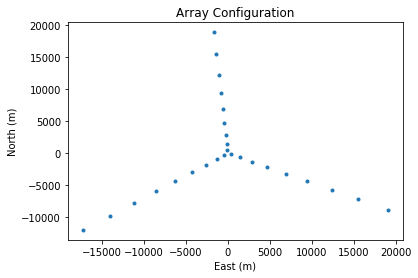

In [52]:
#Antenna Configuration
ants = ENU(coords)
plt.plot(ants[0],ants[1],'.')
plt.title('Array Configuration')
plt.xlabel('East (m)')
plt.ylabel('North (m)')

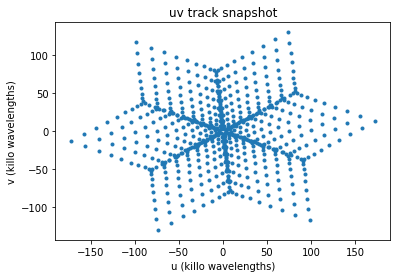

In [53]:
#Snapshot of uv track
uv = uvTrack(coords,LU,lam,deltaU,hU)
plt.plot(uv[:,0],uv[:,1],'.')
plt.title('uv track snapshot')
plt.xlabel('u (killo wavelengths)')
plt.ylabel('v (killo wavelengths)')

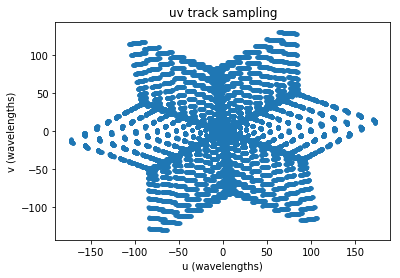

In [54]:
#And plot a track with sampling
sampling = timetrack(coords,LU,lam,deltaU,hU,2*0.99726958*np.pi/(24*60*sampleRate),samples)
#sampling = timetrack(coords,LU,lam,deltaU,hU,2*0.99726958*np.pi/(24*60*sampleRate),samples)
plt.plot(sampling[0],sampling[1],'.')
sample = np.array([sampling[0],sampling[1]])
plt.title('uv track sampling')
plt.xlabel('u (wavelengths)')
plt.ylabel('v (wavelengths)')

In [55]:
sampleC = np.zeros(len(sampling))
for i in np.arange(len(sampling)):
    sampleC[i] = max(sampling[i])
print(max(sampleC))

172.753080388


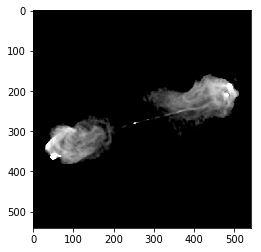

In [56]:
#Image Test
im = PIL.Image.open('radio_galaxy256.png')
plt.imshow(im, 'gray')

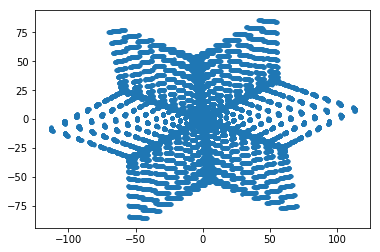

In [57]:
test = ScaleUVTrack(sampling,res,im)
plt.plot(test[0],test[1],'.')

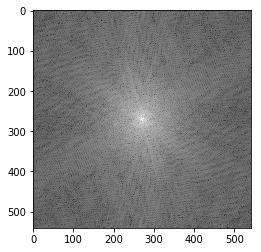

In [58]:
fftim = np.fft.fft2(im)
step = np.fft.fftshift(fftim)
printable = abs(step)
reallyNow = np.log(printable+1)
maxes = np.zeros(len(reallyNow))
for i in np.arange(len(reallyNow)):
    maxes[i] = max(reallyNow[i])
totMax = max(maxes)
seriouslyNow = reallyNow*255/totMax
fourierTrans = PIL.Image.fromarray(seriouslyNow)
plt.imshow(fourierTrans)

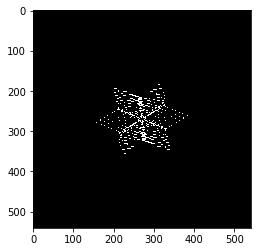

In [59]:
#track image
trackImage = makeMask(im,sampling,res)
plt.imshow(trackImage.convert('LA'))
#trackImage.save('Track.png')

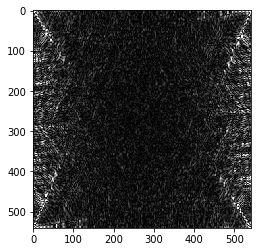

In [82]:
#Sythasied Beam
synBeam = abs(np.fft.ifft2(trackImage.convert('L')))
logBeam = np.log(synBeam+1)
maxes = np.zeros(len(logBeam))
for i in np.arange(len(logBeam)):
    maxes[i] = max(logBeam[i])
totMax = max(maxes)
moddedBeam = logBeam*1475/totMax
synBeamim = PIL.Image.fromarray(moddedBeam)
plt.imshow((synBeamim))

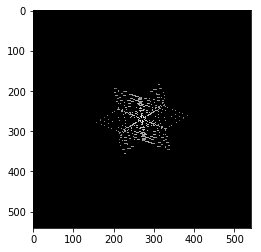

In [61]:
imAndTrack = FourierTimesTrack(im,sampling,res)
abImAndTrack = np.log(abs(imAndTrack)+1)
maxes = np.zeros(len(abImAndTrack))
for i in np.arange(len(abImAndTrack)):
    maxes[i] = max(abImAndTrack[i])
totMax = max(maxes)
scaleImAndTrack = abImAndTrack*255/totMax
#reshapedImage = fixUp.reshape((len(fixUp), len(fixUp[0]))).astype('uint32')*255
finImAndTrack = PIL.Image.fromarray(scaleImAndTrack)
plt.imshow(finImAndTrack,cmap = 'hot')#, clim = (0))
#finImage = finImage.convert('RGB')
#finImage.save('Result.png')

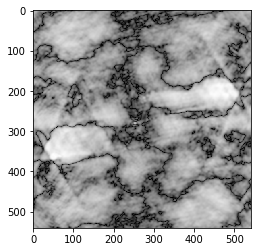

In [62]:
subImage = np.fft.ifft2(np.fft.ifftshift(imAndTrack))
fixUp = np.log(abs(subImage)+1)
maxes = np.zeros(len(fixUp))
for i in np.arange(len(fixUp)):
    maxes[i] = max(fixUp[i])
totMax = max(maxes)
realFixUp = fixUp*255/totMax
#reshapedImage = fixUp.reshape((len(fixUp), len(fixUp[0]))).astype('uint32')*255
finImage = PIL.Image.fromarray(realFixUp)
plt.imshow(finImage,cmap = 'hot')#, clim = (0))
finImage = finImage.convert('RGB')
#finImage.save('Result.png')

In [63]:
print(sampling)

[[ -0.06531348  -0.15968502  -0.27984664 ..., -15.5405735  -32.53864252
  -16.99806901]
 [  4.1714434   10.19876712  17.87325259 ...,   6.03175981  12.62921708
    6.59745727]]


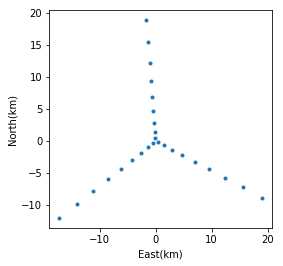

In [85]:
root = Tk()
root.title("Well, let's see")
imDis = PIL.ImageTk.PhotoImage(im.resize([150,150]))
imFour = PIL.ImageTk.PhotoImage(fourierTrans.resize([150,150]))
imCoverage = PIL.ImageTk.PhotoImage(trackImage.resize([150,150]))
imSynBeam = PIL.ImageTk.PhotoImage(synBeamim.resize([150,150]))
imFoAndTr = PIL.ImageTk.PhotoImage(finImAndTrack.resize([150,150]))
imFinal = PIL.ImageTk.PhotoImage(finImage.resize([150,150]))

frame = ttk.Frame(root, padding = '5 5 5 5')
frame.grid(column=0, row=0, sticky=(N,W,E,S))
frame.columnconfigure(0, weight=1)
frame.rowconfigure(0, weight=1)
frame.configure(width=100,height=100)

ttk.Label(frame, text="Configuration Builder").grid(column=1,row=0)

ttk.Label(frame, text="Select Array Configurations").grid(column=1, row=1, sticky=W)
arrayBox = Listbox(frame)
arrayBox.grid(column=1,row=2, rowspan=10)

ttk.Label(frame, text="Display of array").grid(column=3, row=1, sticky=N)

usedArray = []

rB = np.array([0.4364, 1.4337, 2.8747, 4.7095, 6.9065, 9.4434, 12.3027, 15.4706, 18.9357,
          0.4840, 1.5899, 3.1881, 5.2229, 7.6595, 10.4728, 13.6438, 17.157, 21.,
          0.484, 1.5899, 3.1881, 5.2229, 7.6595, 10.4728, 13.6439, 17.1572, 21.])*10**3 #set all the r values in m
thetaA = np.zeros(len(rB)) #set all the theta values in degrees, 0 is parrallel to the surface, 90 points to the zennith
phiA = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,
           125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0,
           245.0, 245.0, 245.0, 245.0, 245.0, 245.0, 245.0, 245.0, 245.0]) #set all the phi values in degrees, 0 is north, 90 is west
phiB = phiA*np.pi/180.
thetaB = thetaA*np.pi/180.
VLAcoords = np.array([rB,thetaB,phiB])
ASKAPcoords = np.array([[1000,1000,1000,1000,1000,1000,1000,1000],[0,0,0,0,0,0,0,0],[0,45/180*np.pi,90/180*np.pi,135/180*np.pi,180/180*np.pi,225/180*np.pi,270/180*np.pi,315/180*np.pi]])
ATCAcoords = np.array([[1000,2000,3000,4000,5000,6000],[0,0,0,0,0,0],[0,0,0,0,0,0]])

latitude = np.array([34.0784*np.pi/180,34.0784*np.pi/180,34.0784*np.pi/180])

arrays = []
arrays.append(coords)

telNames = []
telNames.append('VLA')
telNames.append('ASKAP')
telNames.append('ATCA')

arrCoords = []
arrCoords.append(VLAcoords)
arrCoords.append(ASKAPcoords)
arrCoords.append(ATCAcoords)

arrCoordsENU = []
arrCoordsENU.append(ENUarray(arrCoords[0]))
arrCoordsENU.append(ENUarray(arrCoords[1]))
arrCoordsENU.append(ENUarray(arrCoords[2]))

uvCoords = []
relation = []

arrayBox.insert(END,telNames[0])
arrayBox.insert(END,telNames[1])
arrayBox.insert(END,telNames[2])

rcParams['figure.figsize'] = 4, 4
arrDisFig = plt.figure(1)
Ea = arrCoordsENU[0][0]
No = arrCoordsENU[0][1]
plt.xlabel('East(km)')
plt.ylabel('North(km)')
plt.plot(Ea/1000,No/1000,'.')

arrayDisplay = FigureCanvasTkAgg(arrDisFig,master = frame)

plotDisplay = arrayDisplay.get_tk_widget()
plotDisplay.grid(column=3,row=2,rowspan=10)


arrayBox.bind('<ButtonRelease-1>', ChooseArray)

add = ttk.Button(frame, text = "Add Selected", command = AddSelected)
add.grid(column=1,row=9)

ttk.Label(frame, text="Set Parameters").grid(column=4, row=1, columnspan=2, sticky=N)

ttk.Label(frame,text='Frequency (MHz):').grid(column=4,row=2)
ttk.Label(frame,text='Samples Frequence (/min):').grid(column=4,row=3)
ttk.Label(frame,text='Declination (deg):').grid(column=4,row=4)

freq = StringVar()
samFreq = StringVar()
declin = StringVar()

freq.set(1428.5714285714284)
samFreq.set(1)
declin.set(0)

freqEnt = ttk.Entry(frame,textvariable=freq)
freqEnt.grid(column=5,row=2)
samFreqEnt = ttk.Entry(frame,textvariable=samFreq)
samFreqEnt.grid(column=5,row=3)
decEnt = ttk.Entry(frame,textvariable=declin)
decEnt.grid(column=5,row=4)

minHoVal = 5
maxHoVal = 255
hourMove = 0

ttk.Label(frame, text = "Hour Angle:").grid(column=4,row=5)

hourCanvas = Canvas(frame, width=260,height=50)
hourCanvas.grid(column=4,row=6,columnspan=2)
hourCanvas.create_line(5,25,255,25)
hourCanvas.create_rectangle(minHoVal-3,10,minHoVal+3,40,fill='black')
hourCanvas.create_rectangle(maxHoVal-3,10,maxHoVal+3,40,fill='black')

minHour = StringVar()
maxHour = StringVar()
minHour.set((minHoVal-5)/250*24-12)
maxHour.set((maxHoVal-5)/250*24-12)

minHoLabel = ttk.Entry(frame, textvariable = minHour)
minHoLabel.grid(column=4,row=7)

minHoLabel.bind('<Enter>', minHourDirect)

maxHoLabel = ttk.Entry(frame, textvariable = maxHour)
maxHoLabel.grid(column=5,row=7)

hourCanvas.bind('<1>', lambda e: GrabHourSlide(e))
hourCanvas.bind('<ButtonRelease - 1>',lambda e: ReleaseHour(e))
hourCanvas.bind('<B1-Motion>', lambda e: Slide(e))

ttk.Label(frame, text = "Current Configurations").grid(column=6,row=1)

usedArrays = Listbox(frame)
usedArrays.grid(column=6,row=2, rowspan=10)

delete = ttk.Button(frame, text = "Delete Selected", command = DeleteSelected)
delete.grid(column=6,row=9)

ttk.Label(frame, text="UV Display").grid(column=7, row=1, sticky=N)

rcParams['figure.figsize'] = 4, 4
uvDisFig = plt.figure(2)
U = np.array([])
V = np.array([])

uvDisplay = FigureCanvasTkAgg(uvDisFig,master = frame)

plotUVDisplay = uvDisplay.get_tk_widget()
plotUVDisplay.grid(column=7,row=2,rowspan=10)

#Display Half

imageFrame = ttk.Frame(frame)
imageFrame.grid(column=1,row=20,columnspan=20)

load = ttk.Button(imageFrame, text = 'Load File', command = LoadingImage)
load.grid(column=1, row = 1)

path = StringVar()
loaded = ttk.Entry(imageFrame, width=10, textvariable = path)
loaded.grid(column=2, row = 1)

ttk.Label(imageFrame, text="Pixel Scale (arcsec):").grid(column=1,row=3)
pixScale = StringVar()
pixScale.set(0.5)
scaleEntry = ttk.Entry(imageFrame, width=5, textvariable = pixScale)
scaleEntry.grid(column=2, row = 3)

calculate = ttk.Button(imageFrame, text = 'Run', command = FindEverything)
calculate.grid(column = 6, row = 1)

ttk.Label(imageFrame, text="Reference Image").grid(column=1, row=4, sticky=W)
refCan = Canvas(imageFrame, width = 150, height = 150)
refCan.grid(column=1, row=5, columnspan=2, sticky=W)
shownImage = refCan.create_image(75,75, image=imDis)

ttk.Label(imageFrame, text="Model FFT").grid(column=3, row=4, sticky=(W,S))
fourCan = Canvas(imageFrame, width = 150, height = 150)
fourCan.grid(column=3, row=5, columnspan=2, sticky=W)
fourCan.create_image(75,75, image=imFour)

ttk.Label(imageFrame, text="UV Coverage").grid(column=5, row=4, sticky=S)
uvCan = Canvas(imageFrame, width = 150, height = 150)
uvCan.grid(column=5, row=5, sticky=W)
uvCan.create_image(75,75, image=imCoverage)

ttk.Label(imageFrame, text="Observed FFT").grid(column=7, row=4, sticky=(S))
fftuvCan = Canvas(imageFrame, width = 150, height = 150)
fftuvCan.grid(column=7, row=5, sticky=W)
fftuvCan.create_image(75,75, image=imFoAndTr)

ttk.Label(imageFrame, text="Synthesised beam").grid(column=9, row=4, sticky=E)
synCan = Canvas(imageFrame, width = 150, height = 150)
synCan.grid(column=9, row=5, sticky=W)
synCan.create_image(75,75, image=imSynBeam)

ttk.Label(imageFrame, text="Observed Image").grid(column=11, row=4, sticky=E)
finCan = Canvas(imageFrame, width = 150, height = 150)
finCan.grid(column=11, row=5, sticky=W)
finCan.create_image(75,75, image=imFinal)

#Arrows
c6 = Canvas(imageFrame, width = 75, height = 30)
c6.create_line(50,0,50,30,arrow = LAST)
c6.grid(column=4,row=3)

for child in frame.winfo_children():
    child.grid_configure(padx=5, pady=5)

root.mainloop()